In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, losses
from sklearn.metrics import roc_curve, auc
from utils.preprocess_data_KDD_plus_test import preprocess_data
from utils.plot import plot_roc_curve, plot_combined_roc_curve, save_loss_curve, save_combined_loss_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Preprocess data
train_file_path = os.path.join('data', 'KDDTrain+.csv')
test_file_path = os.path.join('data', 'KDDTest+.csv')
preprocessing_models_folder = os.path.join('preprocessing_pipeline')

X_train, X_test, y_train, y_test = preprocess_data(
    train_file_path=train_file_path,
    test_file_path=test_file_path,
    preprocessing_models_folder=preprocessing_models_folder
)

X_train_original = X_train
y_train_original = y_train

X_train.shape, y_train.shape

((125419, 16), (125419,))

In [3]:
def build_autoencoder(input_shape):
    """Builds a deep Autoencoder model."""
    input_layer = tf.keras.layers.Input(shape=input_shape)
    encoded = tf.keras.layers.Dense(128, activation='relu')(input_layer)
    encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
    encoded = tf.keras.layers.Dense(32, activation='relu')(encoded)
    decoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
    decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
    decoded = tf.keras.layers.Dense(input_shape[0], activation='sigmoid')(decoded)
    
    autoencoder = tf.keras.models.Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder


In [4]:
auto_encoder = build_autoencoder((X_train.shape[1],))
auto_encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208 (832.00 B)

 Trainable params: 208 (832.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
#Take only normal attacks
X_train = X_train[y_train == 1]
y_train = y_train[y_train == 1]
X_train.shape,y_train.shape

((67164, 16), (67164,))

In [6]:
 # Store training loss history for final evaluation
history_final = auto_encoder.fit(X_train, X_train, epochs=10, batch_size=256, shuffle=True, verbose=1)

Epoch 1/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - loss: 1.2190
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 0.8891
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 0.8264
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 0.8715
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 0.8922
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 0.7600
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 0.7409
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 0.8122
Epoch 9/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 0.7397
Epoch 10/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 0.8336


In [7]:
# Function to calculate reconstruction loss
def calculate_reconstruction_loss(data, model):
    reconstructions = model.predict(data)
    reconstruction_errors = np.mean(np.abs(data - reconstructions), axis=1)
    return reconstruction_errors


In [8]:
# Evaluate the model
reconstruction_loss_normal = calculate_reconstruction_loss(X_train_original[y_train_original == 1], auto_encoder)
reconstruction_loss_anomalous = calculate_reconstruction_loss(X_train_original[y_train_original == 0], auto_encoder)

# Print average reconstruction loss
print(f"Average Reconstruction Loss for Normal Data: {np.mean(reconstruction_loss_normal)}")
print(f"Reconstruction Loss for Anomalous Data: {np.mean(reconstruction_loss_anomalous)}")

2099/2099 ━━━━━━━━━━━━━━━━━━━━ 1s 339us/step
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 1s 326us/step
Average Reconstruction Loss for Normal Data: 0.5119110613615723
Reconstruction Loss for Anomalous Data: 0.7943118665384783


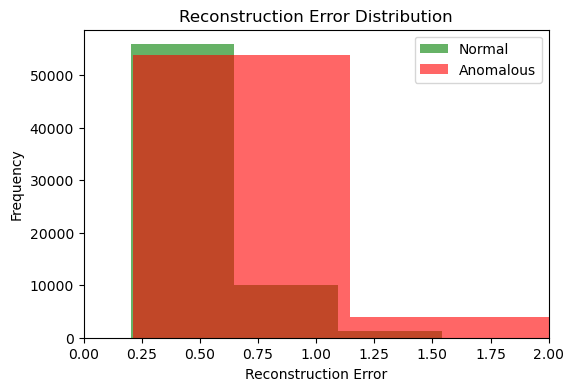

In [9]:
# Visualization of reconstruction error distribution
plt.figure(figsize=(6, 4))
plt.hist(reconstruction_loss_normal, bins=50, alpha=0.6, color='g', label='Normal')
plt.hist(x=reconstruction_loss_anomalous,bins=50,alpha=0.6, color='r', label='Anomalous')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.xlim([0.0, 2.0])
plt.legend()
plt.show()

In [10]:
# Predict reconstructed test data
X_test_reconstructed = auto_encoder.predict(X_test)

# Compute the reconstruction loss for each sample in the test set
reconstruction_loss = np.mean(np.square(X_test - X_test_reconstructed), axis=1)

# Classify each test sample based on a threshold (e.g., 0.5)
threshold = 0.55
predictions = [1 if loss > threshold else 0 for loss in reconstruction_loss]

703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step


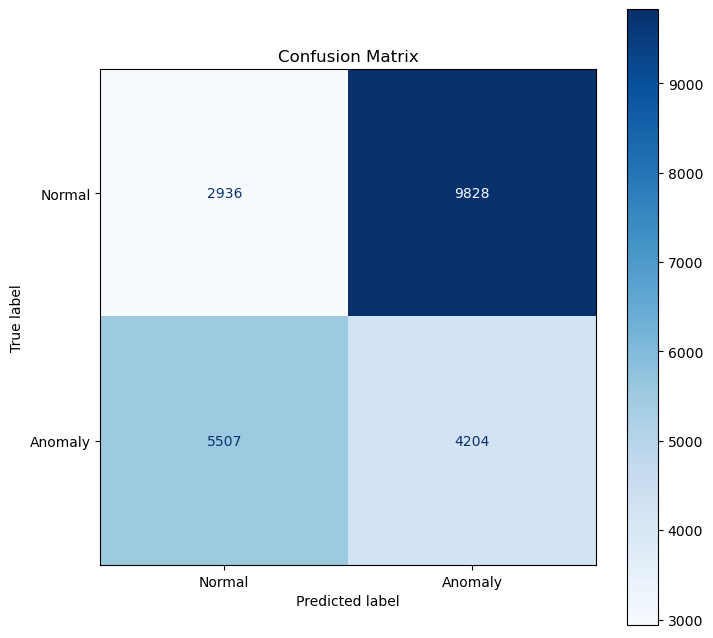

In [11]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()  # Optionally show the plot in a window

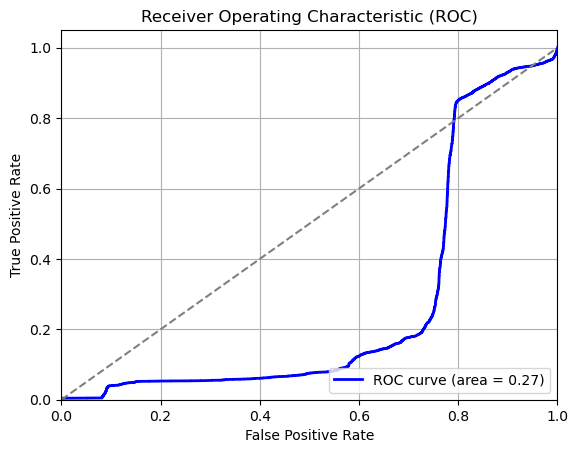

In [12]:
# Step 2: Calculate ROC curve
# It is correct as roc_curve etakes label and probabilites for thresholds
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_loss)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Step 3: Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()  # Optionally show the plot in a window

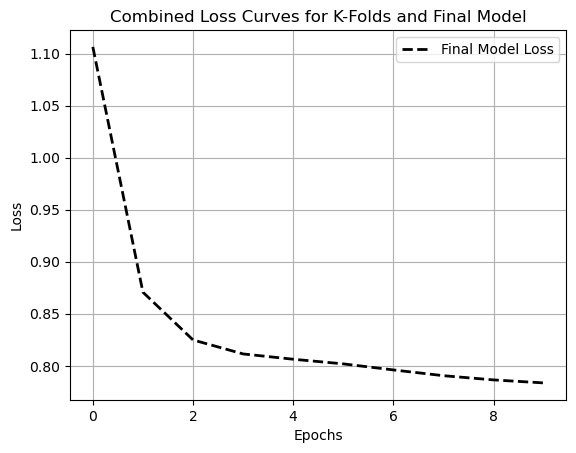

In [14]:
plt.plot(history_final.history['loss'], label='Final Model Loss', linestyle='--', color='black', linewidth=2)

plt.title('Combined Loss Curves for K-Folds and Final Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# VAE